In [2]:
import numpy as np
from os import path
import matplotlib.pyplot as plt
import pickle as pkl

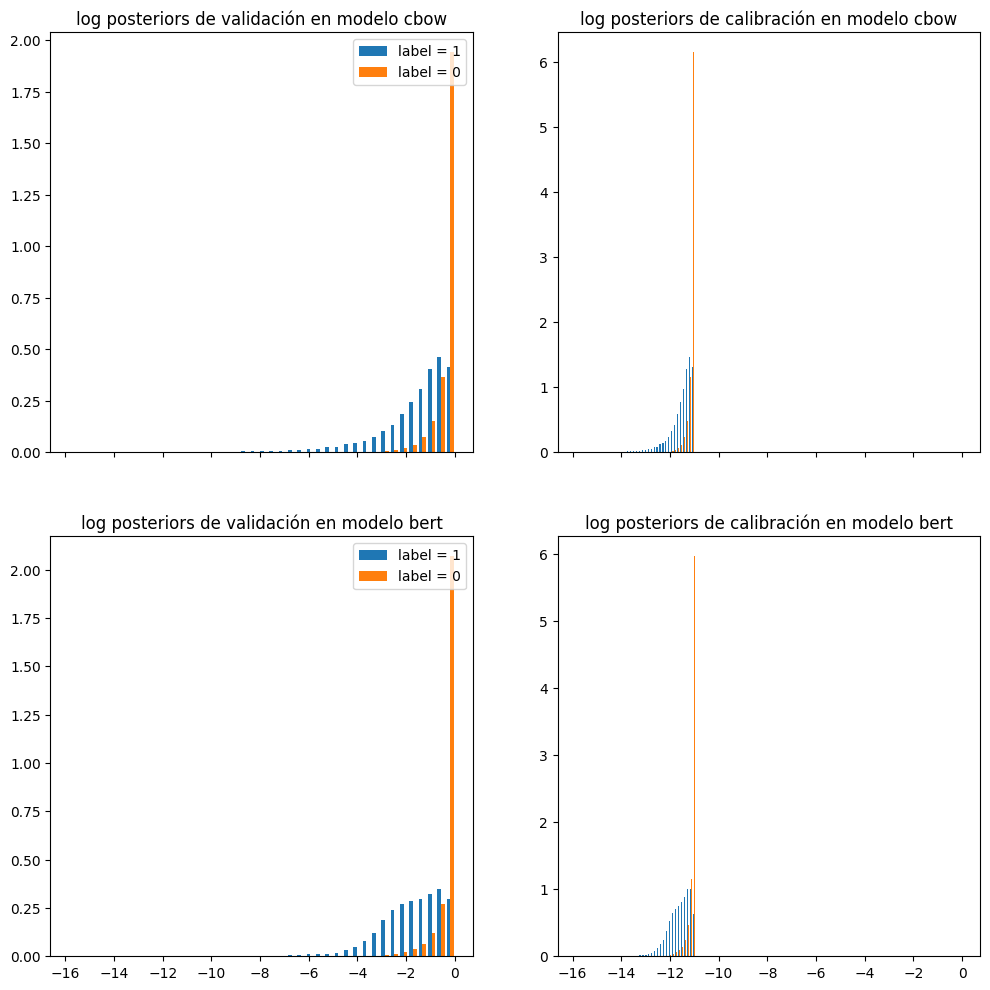

In [17]:

outputs_validation = np.empty(shape=0)
outputs_calibration= np.empty(shape=0)
labels= np.empty(shape=0,dtype=np.int32)
fig, ax = plt.subplots(2, 2, figsize = (12,12),sharex=True)
ax_start=0
for model in ["cbow","bert"]:
   
   with open(path.abspath("../../00_train_system/"+model+"_results.pkl"), 'rb') as f:
      modelOutputs = pkl.load(f)
   calibrationOutputs = np.load(path.abspath(f"../../01_calibrate_system/results/{model}/run00_0/00_Calibration/results.npz"))

   outputs_validation = np.append(outputs_validation,-np.logaddexp(0,modelOutputs["validation"]["logits"]))
   outputs_calibration = np.append(outputs_calibration,calibrationOutputs["logprobs"])
   labels = np.append(labels,modelOutputs["validation"]["labels"])    

   


   class_1_labels = np.where(labels == 0)[0]
   class_2_labels = np.where(labels == 1)[0]
   ax[ax_start][0].set_title(f"log posteriors de validación en modelo "+model)

   ax[ax_start][0].hist([outputs_validation[class_2_labels], outputs_validation[class_1_labels]], 40, label=['label = 1', 'label = 0'],density=True)
   ax[ax_start][0].legend(loc='upper right')

   ax[ax_start][1].set_title(f"log posteriors de calibración en modelo "+model)

   ax[ax_start][1].hist([outputs_calibration[class_2_labels], outputs_calibration[class_1_labels]], 40, label=['label = 1', 'label = 0'],density=True);

   ax_start +=1

